In [1]:
import pickle
import numpy as np
import warnings
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.interpolate import InterpolatedUnivariateSpline
from settings import *
from tools import get_mids

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [2]:
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
warnings.filterwarnings("ignore")

In [3]:
# use only upgoing data to mimick up-going muon track data set
with open("../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    logE_bins, _, _ = pickle.load(f)

logE_mids = get_mids(logE_bins)

In [4]:
# Calculate energy smearing
# this takes a couple of seconds
public_data_hist = np.genfromtxt(
    "../resources/IC86_II_smearing.csv", skip_header=1
)

log_sm_emids = (public_data_hist[:, 0] + public_data_hist[:, 1]) / 2.0
log_sm_ereco_mids = (public_data_hist[:, 4] + public_data_hist[:, 5]) / 2.0
fractional_event_counts = public_data_hist[:, 10]

e_ereco_kdes = gaussian_kde(
    (log_sm_emids, log_sm_ereco_mids), weights=fractional_event_counts
)

# Original smearing matrix

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

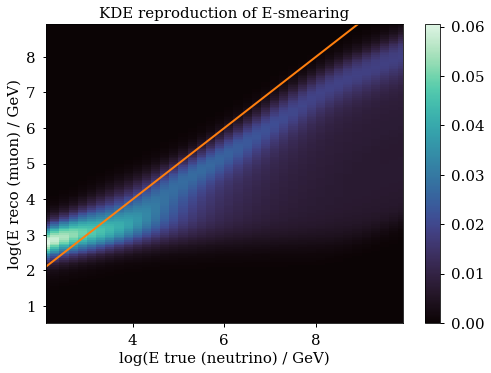

In [5]:
logE_reco_bins = np.arange(0.5, 9, 0.05)
logE_reco_mids = get_mids(logE_reco_bins)
ee, rr = np.meshgrid(logE_mids, logE_reco_mids)

normed_kvals = e_ereco_kdes([ee.flatten(), rr.flatten()]).reshape(len(logE_reco_mids), len(logE_mids))
normed_kvals /= np.sum(normed_kvals, axis=0)
# logE_mids are the same as for effective area binning

plt.grid(False)
plt.pcolormesh(ee, rr, normed_kvals)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(rr), np.max(rr))
plt.xlim(np.min(ee), np.max(ee))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

# Improved smearing matrix

In [6]:
logE_reco_mode = []
# find the mode of E-reco distribution in each slice of E-true
for ii, et in enumerate(logE_mids):
    max_ind = np.argmax(normed_kvals[:,ii])
    logE_reco_mode.append(logE_reco_mids[max_ind])
# Interpolate the E-reco peak position
e_spline = InterpolatedUnivariateSpline(logE_mids, logE_reco_mode)

logE_reco_bins = np.arange(0.5, 9, 0.2)
logE_reco_mids = get_mids(logE_reco_bins)
ee, rr = np.meshgrid(logE_mids, logE_reco_mids)
# shift the KDE evaluation by the difference between expected E peak and the actual E-reco peak
rr_shifted = rr - (logE_mids - e_spline(logE_mids))

ideal_normed_kvals = e_ereco_kdes([ee.flatten(), rr_shifted.flatten()]).reshape(len(logE_reco_mids), len(logE_mids))
ideal_normed_kvals /= np.sum(ideal_normed_kvals, axis=0)

In [9]:
with open("../resources/improved_energy_smearing_kde.pckl", "wb") as f:
    pickle.dump((ideal_normed_kvals, logE_reco_bins), f)

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

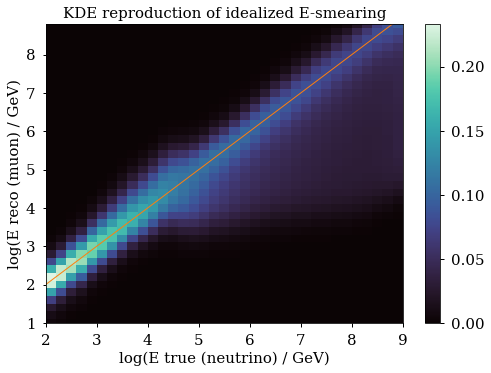

In [8]:
## result
plt.grid(False)
plt.pcolormesh(ee, rr, ideal_normed_kvals)
plt.colorbar()
plt.ylim(1, 8.8)
plt.xlim(2, 9)
plt.plot([2, 10], [2, 10], color="tab:orange", lw=1)
plt.title("KDE reproduction of idealized E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")